# Linear models estimation workbook

In [2]:
%load_ext autoreload
%autoreload 1


In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score, median_absolute_error
import warnings

from computage.utils.data_utils import download_meta, download_dataset
from computage.utils.nan_utils import EN_nan_row_predict,introduce_nans

from computage.models_library.model import LinearMethylationModel

In [4]:
#modelsnames = list(dict_model_names_paths.keys())
modelsnames = ['hrsinchphenoage',
 'lin2016blood_99cpgs',
 'yingdamage',
 'yingadaptage',
 'hannum2013blood',
 'dec2023encen100',
 'yingcausage',
 'horvath2018',
 'vidal-bralo2016blood',
 'lin2016blood_3cpgs',
 'zhangblup2019',
 'zhangenclock2019',
 'phenoage2018',
 'dec2023encen40']

In [5]:
from multiprocessing import Pool

def read_psv_all (file_name):
    return pd.read_csv(file_name,
                       #delimiter='',  # change this as needed                              
                       low_memory=False, index_col = ['Unnamed: 0']
                      ) 

pool = Pool(processes=3) # can change 3 to number of processors you want to utilize
data = read_psv_all('full_blood_HC.csv')
data.head()

meta = pd.read_csv('full_blood_HC_meta.csv',index_col = ['Unnamed: 0'])
meta.shape

y = pd.DataFrame(meta['Age'])
y = y.rename(columns={'Age': 'age'})
data = data.drop(y[y['age'].isnull()].index.tolist())
y = y.dropna()

In [6]:
data.shape

(1078, 487177)

In [7]:
def medae_r2(X,y,model):
    #nan_pct = [0.1]
    X_test = X.reindex(columns=model.features)
    y_test = y
    y_pred_test = model.predict(X_test)
    return median_absolute_error(y_test, y_pred_test),r2_score(y_test, y_pred_test) 

In [8]:
medaes = []
r2s = []
for mymodel in modelsnames:
    try:
        medae, r2 = medae_r2(data, y, LinearMethylationModel(mymodel, imputation='average'))
    except Exception:
        print(Exception)
        medae, r2 = None, None 
    medaes.append(medae)
    r2s.append(r2)       




In [9]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

In [10]:
modelsnames.index('horvath2018')
modelsnames.pop(7)
medaes.pop(7)

49.32305736116612

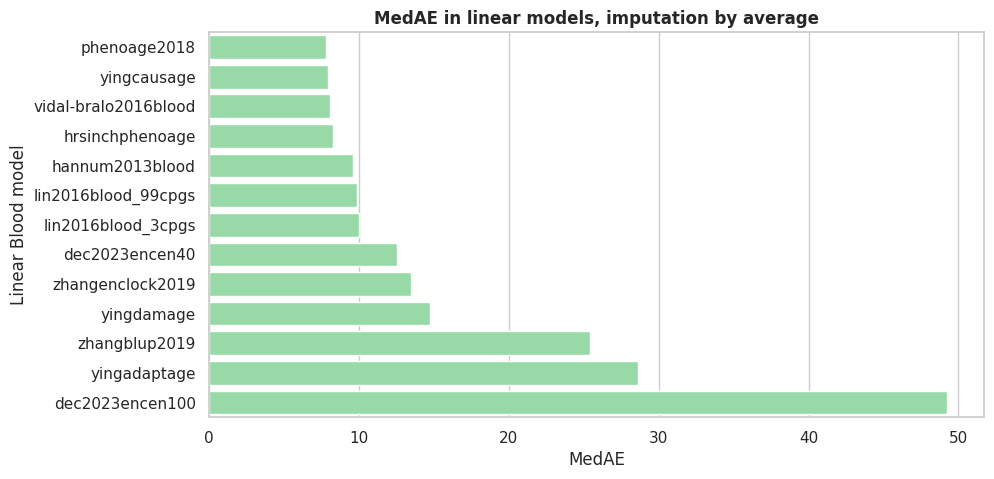

In [11]:
color = (0.2, # redness
         0.4, # greenness
         0.2, # blueness
         0.6 # transparency
         ) 
import seaborn as sns
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize = (10, 5))
#plt.figure(figsize = (10, 5))
dfplot = pd.DataFrame({"modelsnames": modelsnames,
                   "medaes": medaes})
# Plot the total crashes
sns.set_color_codes("pastel")
dfplot = dfplot.sort_values('medaes')
sns.barplot(data=dfplot,x = 'medaes', y='modelsnames', color = 'g')


# Add a legend and informative axis label
#ax.legend(ncol=2, loc="lower right", frameon=True)
#sns.despine(left=True, bottom=True)


ax.set_xlabel('MedAE')
ax.set_ylabel('Linear Blood model')
ax.set_title('MedAE in linear models, imputation by average', weight='bold')
#ax.legend(title='linear model')

plt.show()

'phenoage2018'
'yingcausage',
'vidal-bralo2016blood',
'hrsinchphenoage',
'hannum2013blood'

In [20]:
def pred(X,model):
   
    X_test = X.reindex(columns=model.features)
    
    y_pred_test = model.predict(X_test)
    return y_pred_test 

In [27]:
topmodels = ['actual age','phenoage2018',
'yingcausage',
'vidal-bralo2016blood',
'hrsinchphenoage',
'hannum2013blood']
y_reset = y.reset_index(drop=True)
top_models_preds = [y_reset]
for model in topmodels[1:]:
    # set the first column as index
    y_pred_test = pred(data,LinearMethylationModel(model, imputation='average'))
    top_models_preds.append(pd.DataFrame(y_pred_test))
general = pd.concat(top_models_preds, axis=1, join='outer', ignore_index=True)
#general.columns = ['actual age', ]
#general = general.loc[:,1:]

In [28]:
general.columns = topmodels
general

,actual age,phenoage2018,yingcausage,vidal-bralo2016blood,hrsinchphenoage,hannum2013blood
0,79.0,68.384659,83.869571,52.793431,72.398569,83.008916
1,90.0,71.624863,85.038432,67.276990,87.072536,85.649493
2,78.0,74.193826,85.643776,64.381156,77.678722,82.866493
3,84.0,69.468992,79.390100,69.294662,69.233209,76.931659
4,76.0,69.290751,80.310157,60.664035,67.667280,77.603702
...,...,...,...,...,...,...
1073,52.0,66.319520,64.411564,49.430215,64.744080,67.055424
1074,45.0,60.034890,55.408574,45.579486,59.497948,61.312530
1075,55.0,61.891068,58.575883,45.088937,64.133545,62.439093
1076,49.0,59.135157,58.323247,42.829291,65.122295,64.007470


In [29]:
#general.set_index(general.columns[0], inplace=True)
#general

<Axes: xlabel='actual age', ylabel='prediction'>

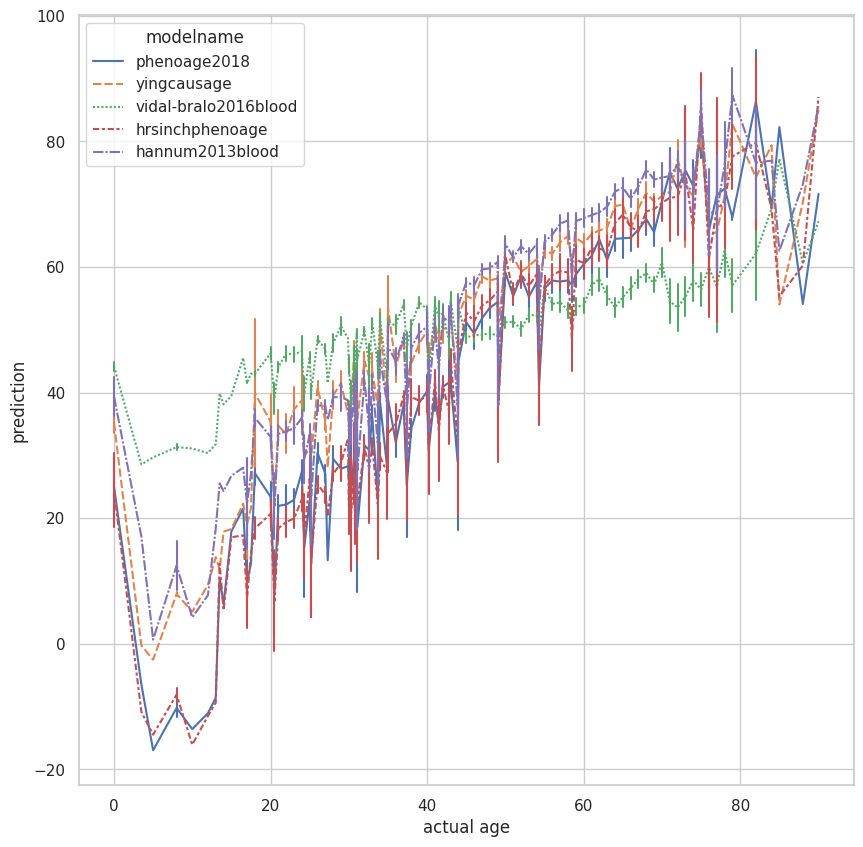

In [30]:
dfm = general.melt('actual age', var_name='modelname', value_name='prediction')

fig, ax = plt.subplots(figsize = (10, 10))
sns.set_theme(style="whitegrid")
sns.lineplot(data=dfm, y='prediction', x = 'actual age', hue='modelname' , style='modelname',err_style="bars", errorbar=("se", 1))

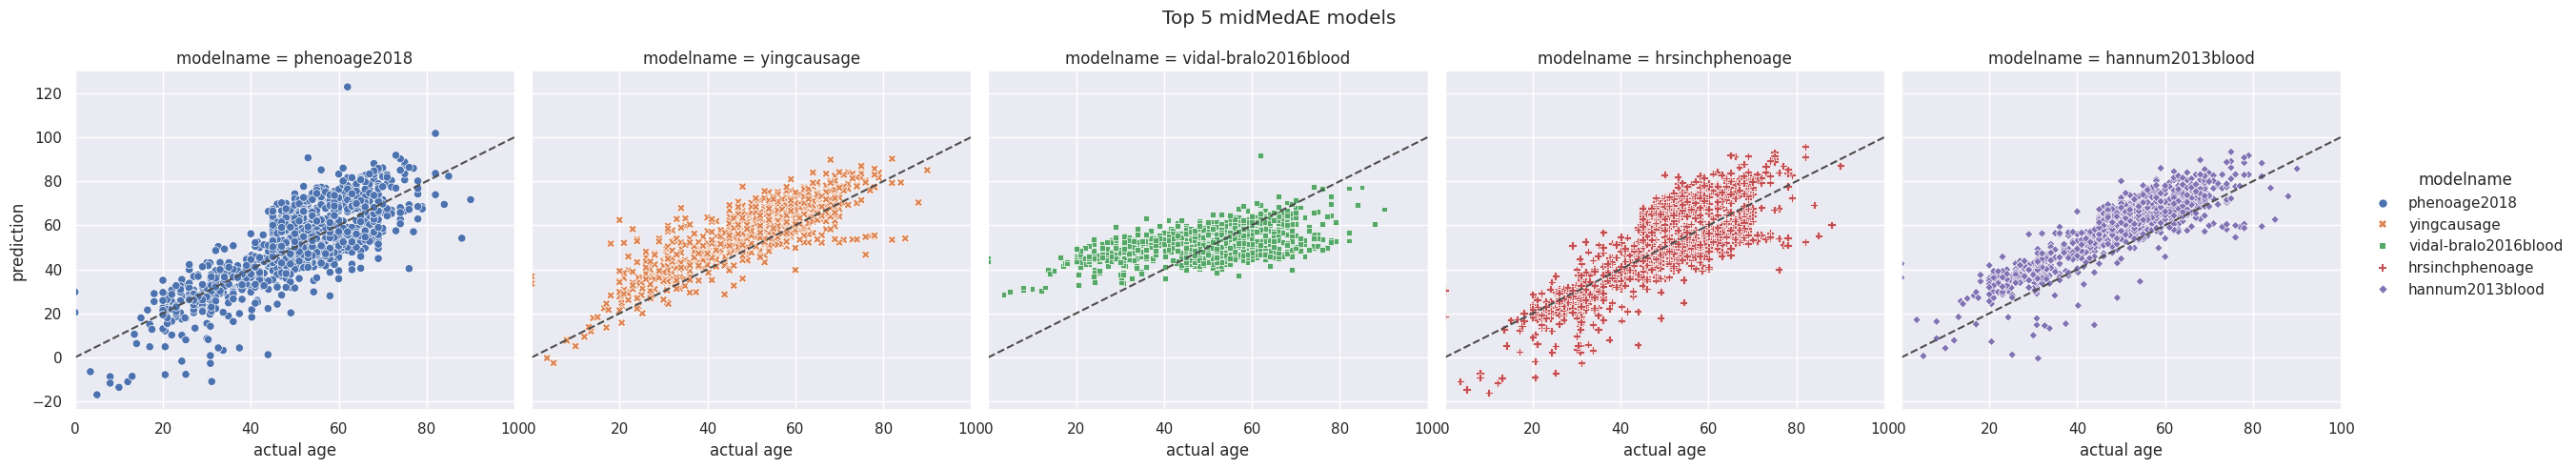

In [53]:
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
p1 = sns.relplot(data=dfm, y='prediction', x = 'actual age', hue='modelname', style='modelname',col='modelname')
#p1.set_xlim(1, 120)
p1.set(xlim=(0, 100))

xx = np.linspace(0, 100, 2)
yy = xx

for ax in p1.axes.flat:
    ax.plot(xx,yy,ls="--", c=".3")

p1.fig.subplots_adjust(top = 0.85)
p1.fig.suptitle('Top 5 midMedAE models' )
p1.savefig('figures/top5preds.png')    
plt.show()    

<Axes: xlabel='actual age', ylabel='prediction'>

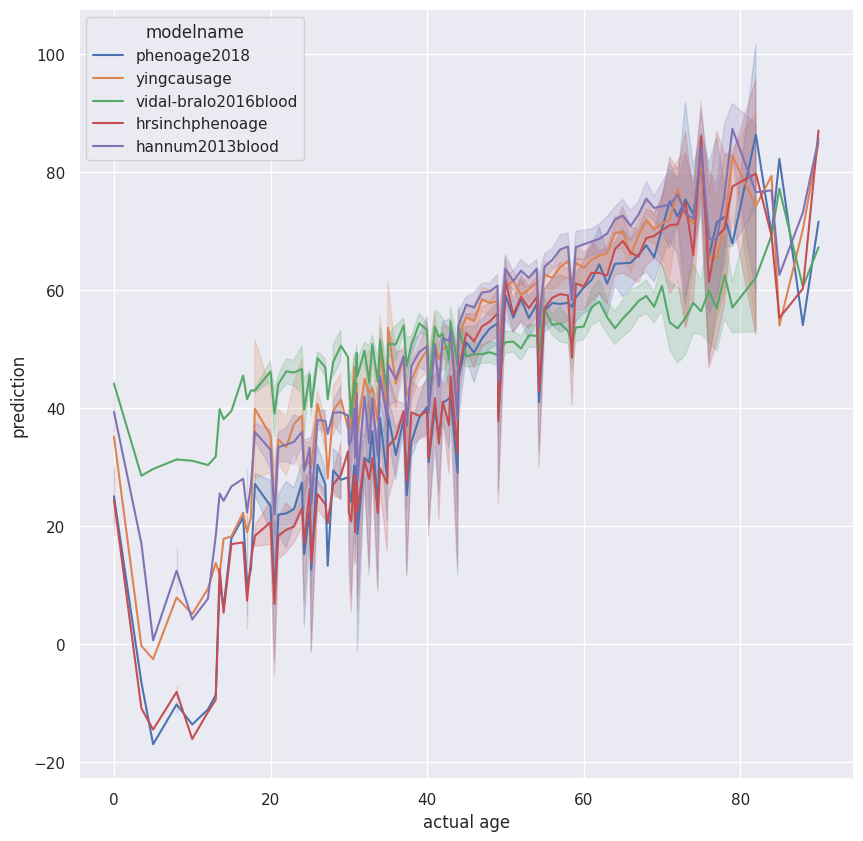

In [32]:
#fig, ax = plt.subplots(figsize = (10, 10))
fig, ax = plt.subplots(figsize = (10, 10))
sns.lineplot(data=dfm, y='prediction', x = 'actual age', hue='modelname' )